In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

from glob import glob
import json
import csv
import os

import cv2
import numpy as np

In [3]:
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import LeakyReLU, ELU, Dropout

Using TensorFlow backend.


In [4]:
from keras.optimizers import Adam
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from utils import read_samples
from utils import ImageGenerator
from utils import CenterImageGenerator

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
ROOT_DIR = os.path.join(os.getcwd(), '../')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

In [8]:
samples = read_samples(DATA_DIR)
samples.pop(0)

Loaded 8037 samples.


['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [9]:
def append_path(line):
    line[0] = os.path.join(DATA_DIR, 'sample-data', line[0].strip())
    line[1] = os.path.join(DATA_DIR, 'sample-data', line[1].strip())
    line[2] = os.path.join(DATA_DIR, 'sample-data', line[2].strip())
    return line

In [10]:
samples = [append_path(line) for line in samples]

In [11]:
samples[0]

['/home/carnd/CarND-Behavioral-Cloning-P3/notebooks/../data/sample-data/IMG/center_2016_12_01_13_30_48_287.jpg',
 '/home/carnd/CarND-Behavioral-Cloning-P3/notebooks/../data/sample-data/IMG/left_2016_12_01_13_30_48_287.jpg',
 '/home/carnd/CarND-Behavioral-Cloning-P3/notebooks/../data/sample-data/IMG/right_2016_12_01_13_30_48_287.jpg',
 ' 0',
 ' 0',
 ' 0',
 ' 22.14829']

In [12]:
train_set, test_set = train_test_split(samples, test_size=0.1)
train_set, valid_set = train_test_split(train_set, test_size=0.1)

In [71]:
train_iterator = ImageGenerator(train_set, batch_size=128, corr=0.25)
valid_iterator = CenterImageGenerator(valid_set, batch_size=128, gray=False)
test_iterator = CenterImageGenerator(test_set, batch_size=128, gray=False)

In [72]:
def comma_model():
    ch, row, col = 1, 160, 320  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Conv2D(8, (8, 8), strides=(4, 4), padding="same"))
    model.add(ELU())
    model.add(Conv2D(16, (5, 5), strides=(2, 2), padding="same"))
    model.add(ELU())
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    # adam = Adam(0.001)
    model.compile(optimizer='adam', loss="mse")
    return model

In [73]:
model = comma_model()

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 160, 320, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 80, 8)         520       
_________________________________________________________________
elu_14 (ELU)                 (None, 40, 80, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 40, 16)        3216      
_________________________________________________________________
elu_15 (ELU)                 (None, 20, 40, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 20, 32)        12832     
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
__________

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, 
                               patience=2, verbose=1, mode='auto')
filepath = 'comma.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, 
                save_weights_only=False, mode='auto', period=1)

In [76]:
model.fit_generator(generator=train_iterator, epochs=7, 
                    validation_data=valid_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_steps=len(valid_iterator),
                    callbacks=[early_stopping, checkpoint]
                   )

Epoch 1/7
306/306 [==============================] - 80s - loss: 0.2582 - val_loss: 0.0346
Epoch 2/7
306/306 [==============================] - 80s - loss: 0.0166 - val_loss: 0.0323
Epoch 3/7
306/306 [==============================] - 79s - loss: 0.0124 - val_loss: 0.0300
Epoch 4/7
306/306 [==============================] - 78s - loss: 0.0103 - val_loss: 0.0325
Epoch 5/7
306/306 [==============================] - 78s - loss: 0.0088 - val_loss: 0.0232
Epoch 6/7
306/306 [==============================] - 78s - loss: 0.0075 - val_loss: 0.0247
Epoch 7/7
306/306 [==============================] - 78s - loss: 0.0073 - val_loss: 0.0293


In [77]:
results = model.evaluate_generator(generator=test_iterator, steps=len(test_iterator))

In [78]:
results

0.026992433305297579

In [28]:
def random_shear(image, steering, shear_range=200):
    rows, cols, _ = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)  
    return image, steering + dsteering

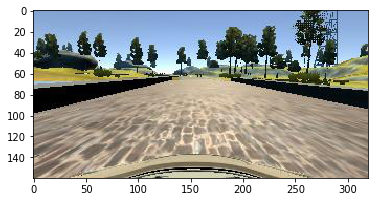

In [33]:
test_image = samples[0][0]
image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

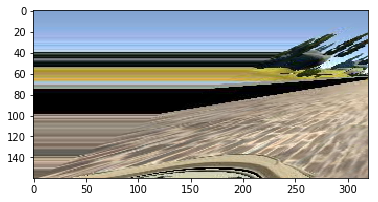

In [49]:
warped, wangle = random_shear(image, float(samples[0][3]))
plt.imshow(warped)

In [50]:
wangle

0.749619781962827

In [39]:
h,w,_ = image.shape
horizon = 2*h/5
v_shift = np.random.randint(-h/8,h/8)
pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
M = cv2.getPerspectiveTransform(pts1,pts2)
new_img = cv2.warpPerspective(image,M,(w,h), borderMode=cv2.BORDER_REPLICATE)

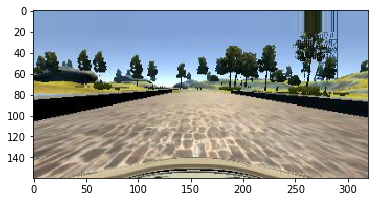

In [40]:
plt.imshow(new_img)

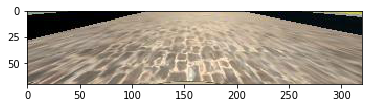

In [52]:
plt.imshow(image[70:140])

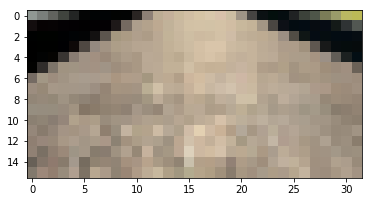

In [58]:
plt.imshow(cv2.resize(image[70:140], (32, 16), interpolation=cv2.INTER_AREA))

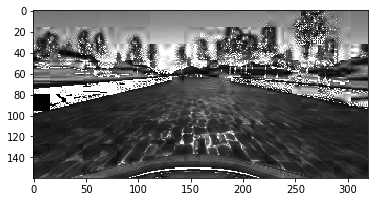

In [59]:
s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:, :, 2]
plt.imshow(s, cmap='gray')

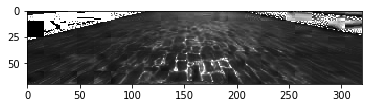

In [62]:
plt.imshow(s[70:140], cmap='gray')